## Nome: Samuele Pio Lipani

In [1]:
library(ggplot2)
library(grid)
library(gridExtra)
library(tidyverse)

Warning message:
"package 'gridExtra' was built under R version 4.0.5"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::combine() masks gridExtra::combine()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()



## Esercizio 1 - six boxes toy model con user input

Il gioco:
- vi sono 6 scatole indistinguibili ognuna contenente 5 pietre nere oppure bianche
- la composizione differisce per ciascuna
- le scatole sono denominate $H_j$, in base al numero di pietre bianche che contengono con $j=0,1,\dots,5$

![Six boxes toy model](six.PNG)
(Qui avrei voluto mettere un link al mio github per mostrare l'immagine ma non funziona)

Le regole sono altrettanto semplici:
- si sceglie una scatola randomicamente dalle 6 a disposizione senza conoscerne il contenuto
- si prova ad indovinare il contenuto della stessa estraendo a random una pietra dalla stessa
- la pietra viene estratta e poi reinserita nella scatola

Sia $I$ l'informazione che possediamo a priori:
- $H_j$ è la box selezionata ($j=0,1\dots,5$)
- $E_w$ è l'evento estrazione di una pietra bianca
- $E_b$ è l'evento estrazione di una pietra nera

Per descrivere opportunamente il problema bisogna individuare quale esso realmente sia. 
- qual è la probabilità di selezionare una box?
- dopo che estraiamo una pietra qual è la probabilità che essa sia bianca, $P(E_w|I)$, o nera, $P(E_b|I)$ nell'estrazione successiva?
- come è aggiornato il valore della probabilità di una successiva estrazione dopo che una pietra viene estratta e svelato il suo colore?

Lo spazio degli eventi $\Omega$ può essere decomposto a partire dagli eventi $E_k, \ k=b,\dots,w$,  oppure tramite $H_j$. Siamo tuttavia incerti sulle probabilità delle 12 combinazioni $E_k \cap H_j$.
$E_k$ e $H_j$ formano una classe completa di ipotesi e ciascun evento si può scrivere come la somma logica dei suoi costituenti sfruttando la marginalizzazione di $E_k \cap H_j$ rispetto a $j$ trovando $E_k$ oppure rispetto a $k$ ottenendo $H_j$. 
Infine poichè gli eventi $E_k \cap H_j$ sono mutuamente esclusivi è possibile ricavare la probabilità di estrazione di una scatola e di una pietra come:

$$ P(E_k) = \sum_jP(E_k \cap H_j|I) = \sum_j P(E_k|H_jI)P(H_j|I) \\ P(H_j) = \sum_jP(H_j \cap E_k|I) = \sum_j P(H_j|E_kI)P(E_k|I)$$

Quelli che possiamo osservare esplicitamente sono gli eventi $E_k$ mentre $H_j$ sono le cause che subiranno il processo di inferenza Bayesiana.
Dopo un po' di algebra si giunge alla formula ricorsiva che restituisce la probabilità di estrarre una pietra bianca oppure nera dalla j-esima scatola:

$$P(H_j|E_wI_n) = \frac{j/5 \cdot P(H_j|I_{n-1})}{1/2} \\ P(H_j|E_bI) = \frac{(5-j)/5 \cdot P(H_j|I_{n-1})}{1/2}$$

A partire da queste due relazioni è possibile calcolare le due probabilità al variare del colore estratto fornito come input dall'user e per ogni estrazione $n$. 
Durante lo step n-esimo il prior che utilizziamo fa riferimento al posterior ottenuto dallo step precedente n-1, il valore iniziale è $1/6$ in quanto decidiamo che la probabilità di scegliere una scatola sia uniformemente distribuita per tutte e sei.


In [2]:
# implementazione al variare dell'input b/w dell'esperimento delle sei scatole 

likelihood <- function(i,j) {
    #i <- readline(prompt="Colore estratto: ")
    #if(i == "x") sprintf("Processo interrotto") 
    l <- ifelse(i == "w", j/5, ifelse(i == "b", (5-j)/5, sprintf("Input sbagliato riprovare")))
    return(l)
}

plotbox  <- function()
# likelihood(,5)

# vorrei una funzione che continua a funzionare fino a quando non inserisco un particolare input, ciascuna iterazione mi restituisce il 
# posterior e quando la interrompo fa un plot dei posterior inferred al variare dello step in cui sono stati calcolati.
# Tale funzione ogni iterazione calcola 6 posterior diversi che memorizza all'interno di sei vettori differenti. 

posterior <- function(i = readline(prompt = "Premere x per interrompere, colore estratto: ")) {
    prior <- rep(1/6,6)
    group <- data.frame(H0=0.167,H1=0.167,H2=0.167,H3=0.167,H4=0.167,H5=0.167, Ex=NA)  
    # inizializzandolo con il prior uniforme 
    # posteriors <- c("h0","h1","h2","h3","h4","h5")
    # creo un dataframe in modo da avere a portata di mano tutti e sei i posteriors e poter accedere alle singole colonne del dataframe 
    # contemporaneamente tramite l'asseganzione group[,posteriors] <- c() oppure aggiungere una riga direttamente al dataframe tramite 
    # la scrittura group[nrow(group) + 1,] <- c()

    while(i != "x") {
        
        likeli <- rep(NA,length(group)-1) # perchè va tolta la colonna con il colore estratto
        for(j in 0:5) {
            likeli[j+1] <- likelihood(i,j)
            }
        # nella sezione precedente calcolo la likelihood una volta per tutte. Da questo momento in poi bisogna aggiungere al dataframe per ogni 
        # nuova riga il posterior con un prior che parte da 1/6 e si aggiorna ad ogni iterazione diventando il posterior precedente

        group[nrow(group) + 1,] <-  c((likeli * as.numeric(prior))/(sum(likeli * as.numeric(prior))), i)
        
        # all'ultima colonna viene assegnato il colore dell'estrazione inserito da input
        # adesso aggiorno il prior attraverso l'ultima riga del dataframe che ho appena calcolato 
        prior <- group[nrow(group),-length(group)]
        
        print("Current posterior:")
        print(prior); flush.console()
        
        
        i <- readline(prompt = "Colore estratto: ")
        # infine per mantenere il while attivo mi basta chiedere nuovamente quale sia il colore estratto, in questo modo me lo trovo già pronto
        # per l'iterazione successiva 
        }
    
    return(group)
}

In [3]:
# la funzione postrior oltre a memorizzare in un oggetto che ho assegnato a group un dataframe contenente tutta la cronologia delle estrazioni
# mi permette di vedere quanto vale il posterior per ciascuna scatola ad ogni iterazione stampando quello che nel ciclo ho già assegnato a 
# prior per essere per l'appunto il nuovo prior della successiva esecuzione

group <- posterior()

Colore estratto:  w


[1] "Current osterior:"
  H0                 H1                H2  H3                H4
2  0 0.0666666666666667 0.133333333333333 0.2 0.266666666666667
                 H5
2 0.333333333333333


Colore estratto:  w


[1] "Current osterior:"
  H0                 H1                 H2                H3                H4
3  0 0.0181818181818182 0.0727272727272726 0.163636363636364 0.290909090909091
                 H5
3 0.454545454545454


Colore estratto:  w


[1] "Current osterior:"
  H0                  H1                 H2   H3                H4
4  0 0.00444444444444445 0.0355555555555555 0.12 0.284444444444445
                 H5
4 0.555555555555555


Colore estratto:  w


[1] "Current osterior:"
  H0                  H1                 H2                 H3
5  0 0.00102145045965271 0.0163432073544433 0.0827374872318693
                 H4                H5
5 0.261491317671094 0.638406537282941


Colore estratto:  w


[1] "Current osterior:"
  H0                   H1                  H2                 H3
6  0 0.000225988700564972 0.00723163841807909 0.0549152542372882
                 H4                H5
6 0.231412429378532 0.706214689265536


Colore estratto:  w


[1] "Current osterior:"
  H0                   H1                  H2                 H3
7  0 4.87448208627834e-05 0.00311966853521813 0.0355349744089691
                 H4                H5
7 0.199658786253961 0.761637825980989


Colore estratto:  w


[1] "Current osterior:"
  H0                   H1                  H2                H3
8  0 1.03279111799639e-05 0.00132197263103537 0.022587141750581
                 H4                H5
8 0.169212496772528 0.806868060934675


Colore estratto:  b


[1] "Current osterior:"
  H0                  H1                 H2               H3                H4
9  0 0.00018916107065166 0.0181594627825593 0.20684763075759 0.774803745389199
  H5
9  0


Colore estratto:  x


In [4]:
# l'oggetto risultante è dunque un dataframe contenente la cronologia dell'inferenza sulle sei scatole per ciascuna estrazione
group

,H0,H1,H2,H3,H4,H5,Ex
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,0.167,0.167,0.167,0.167,0.167,0.167,NA
2,0,0.0666666666666667,0.133333333333333,0.2,0.266666666666667,0.333333333333333,w
3,0,0.0181818181818182,0.0727272727272726,0.163636363636364,0.290909090909091,0.454545454545454,w
4,0,0.00444444444444445,0.0355555555555555,0.12,0.284444444444445,0.555555555555555,w
5,0,0.00102145045965271,0.0163432073544433,0.0827374872318693,0.261491317671094,0.638406537282941,w
6,0,0.000225988700564972,0.00723163841807909,0.0549152542372882,0.231412429378532,0.706214689265536,w
7,0,4.87448208627834e-05,0.00311966853521813,0.0355349744089691,0.199658786253961,0.761637825980989,w
8,0,1.03279111799639e-05,0.00132197263103537,0.022587141750581,0.169212496772528,0.806868060934675,w
9,0,0.00018916107065166,0.0181594627825593,0.20684763075759,0.774803745389199,0,b


In [5]:
# Plot che cambia ad ogni iterazione: inserisco il plot direttamente all'interno della funzione posterior nel ciclo while

In [6]:
plot.posterior <- function(posterior, index) {
    df.ggplot <- data.frame(0:5, posterior)
    names(df.ggplot) <- c("box_hypothesis", "posterior")
    ggplot(data = df.ggplot, aes(x = box_hypothesis, y = posterior)) + geom_point() + geom_line() + ggtitle(sprintf("Extraction n. %d", index))
}

In [7]:
posterior1 <- function(i = readline(prompt = "Colore estratto: ")) {
    prior <- rep(1/6,6)
    group <- data.frame(H0=0.167,H1=0.167,H2=0.167,H3=0.167,H4=0.167,H5=0.167, Ex=NA)  
    while(i != "x") {
        likeli <- rep(NA,length(group)-1) 
        for(j in 0:5) {
            likeli[j+1] <- likelihood(i,j)
            }
        group[nrow(group) + 1,] <-  c((likeli * as.numeric(prior))/(sum(likeli * as.numeric(prior))), i)
        prior <- group[nrow(group),-length(group)]
        
        # print(plot.posterior(as.numeric(prior), nrow(group)-1)) non funziona in jupyter quindi plotto direttamente fuori dal ciclo
        # altrimenti si vedono i plot in ritardo dopo almeno tre iterazioni iniziano ad essere mostrati
        
        i <- readline(prompt = "Colore estratto: ")
        }
    print(plot.posterior(as.numeric(prior), nrow(group)-1))
    return(group)
}

Colore estratto:  w
Colore estratto:  w
Colore estratto:  w
Colore estratto:  w
Colore estratto:  w
Colore estratto:  w
Colore estratto:  b
Colore estratto:  x


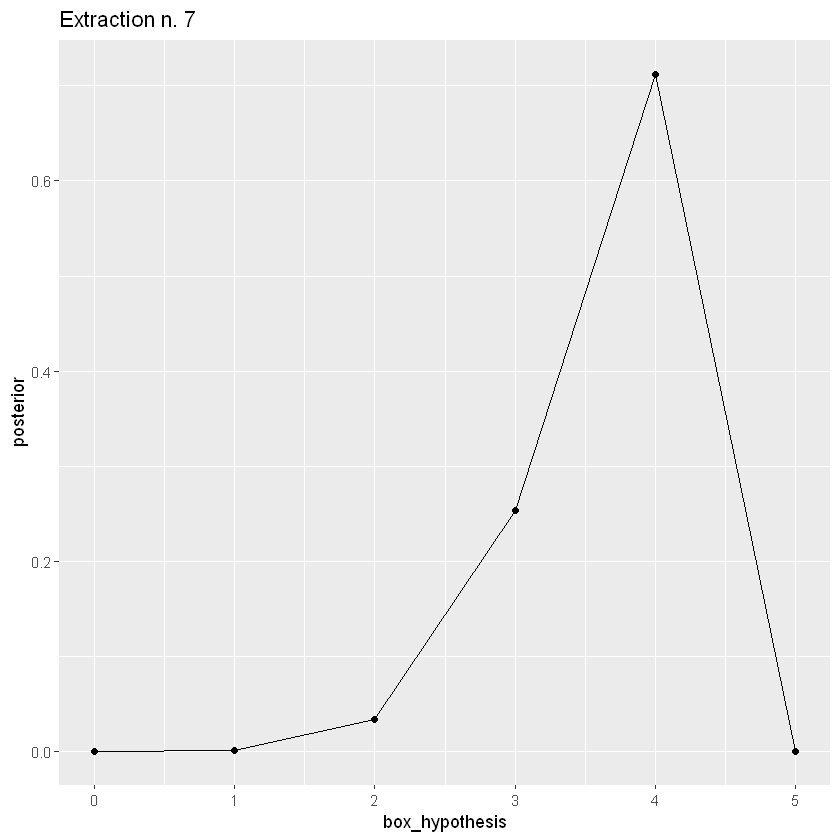

In [8]:
group1 <- posterior1()

## Esercizio 2 - Simulazione del six box model senza user input 

A differenza del caso precedente posso scegliere una cassa conoscendo il suo contenuto; successivamente estraggo $n$ samples randomicamente dalla stessa e confronto tramite inferenza Bayesiana quale sia la probabilità di aver estratto una pietra proprio da quella scatola selezionata.

[1] "The unknown box contains 5 white balls and 0 black balls (hypothesis H5)"


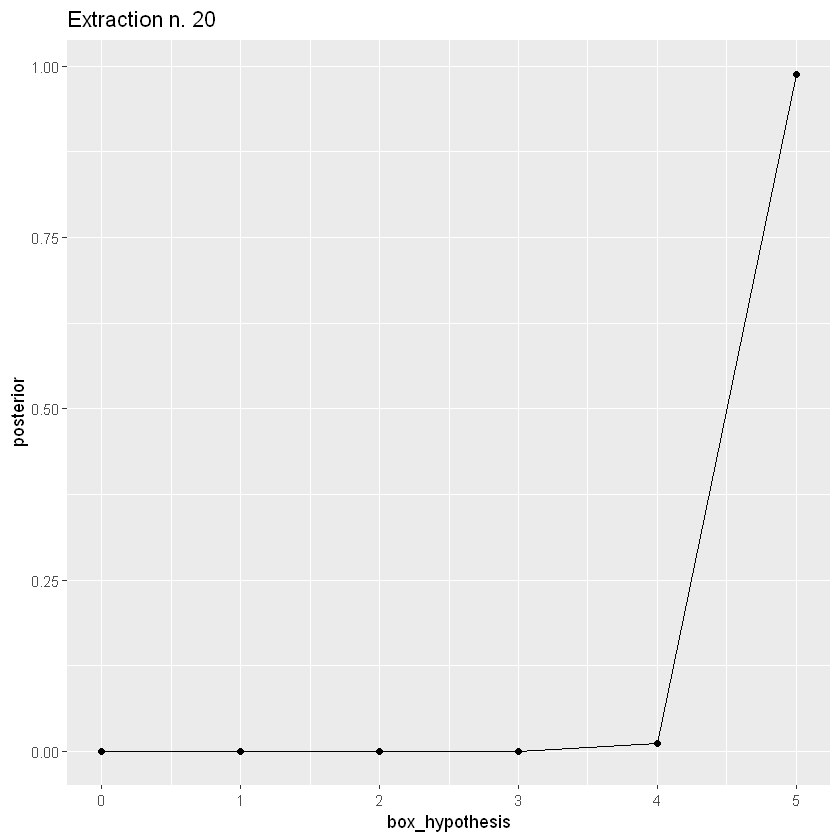

In [139]:
set.seed(12345)

n.white <- sample(0:5)[1]
print(sprintf("The unknown box contains %d white balls and %d black balls (hypothesis H%d)", n.white, (5-n.white), n.white))
box <- c(rep(0, times = n.white), rep(1, times = 5-n.white))

rbox <- function(box) sample(box)[1]

colors.array <- c("w", "b")
# 0 è white mentre 1 è black
n.draws <- 20

prior1 <- rep(1/6,6)
group1 <- data.frame(H0=0.167,H1=0.167,H2=0.167,H3=0.167,H4=0.167,H5=0.167)  

for(e in 1:n.draws) {
    likeli1 <- rep(NA,length(group1)) 
    
    extracted.color <- rbox(box)
    for(j in 0:5) {
        likeli1[j+1] <- likelihood(colors.array[extracted.color+1],j)
        }
    group1[nrow(group1) + 1,] <-  (likeli1 * prior1)/(sum(likeli1 * prior1))
    
    prior1 <- group1[nrow(group1),]
    
    }

plot.posterior(as.numeric(prior1), nrow(group1)-1)


## Esercizio 3 - Estrarre samples da una Erlang distribution $Gamma(m,\beta)$

A partire da una sequenza di random variables $X_i \sim \ Gamma(\alpha _j,\beta)$ si osserva una proprietà importante di una distribuzione esponenziale: 

$$ Y = \sum_{j=1}^n X_j \sim  \ Gamma(\alpha,\beta) \ \ \  \text{con} \ \alpha = \sum_{j=1}^n \alpha_j$$

Se $\alpha$ è un numero intero $m$ allora è possibile ottenere la distribuzione di Erlang sommando n indipendenti random variables esponenziali $X_j \sim \ Exp(\beta)$: 

$$ Y = \beta \sum_{j=1}^n -log(U_j) = -\beta \ log \prod_{j=1}^n U_j$$

dove $U_j$ sono samples uniformemente distribuiti in $[0,1]$ utilizzati per estrarre random variables da una distribuzione esponenziale tramite l'inverse sampling.

Posso estrarre samples dalla distribuzione di Erlang tramite:
- definizione precedente della $Y$ come somma di logaritmi a partire da una variabile distribuita uniformemente in $[0,1]$
- utilizzare la funzione base di r in cui specifichiamo come primo parametro della dsitribuzione esponenziale un numero intero
- inverse sampling 


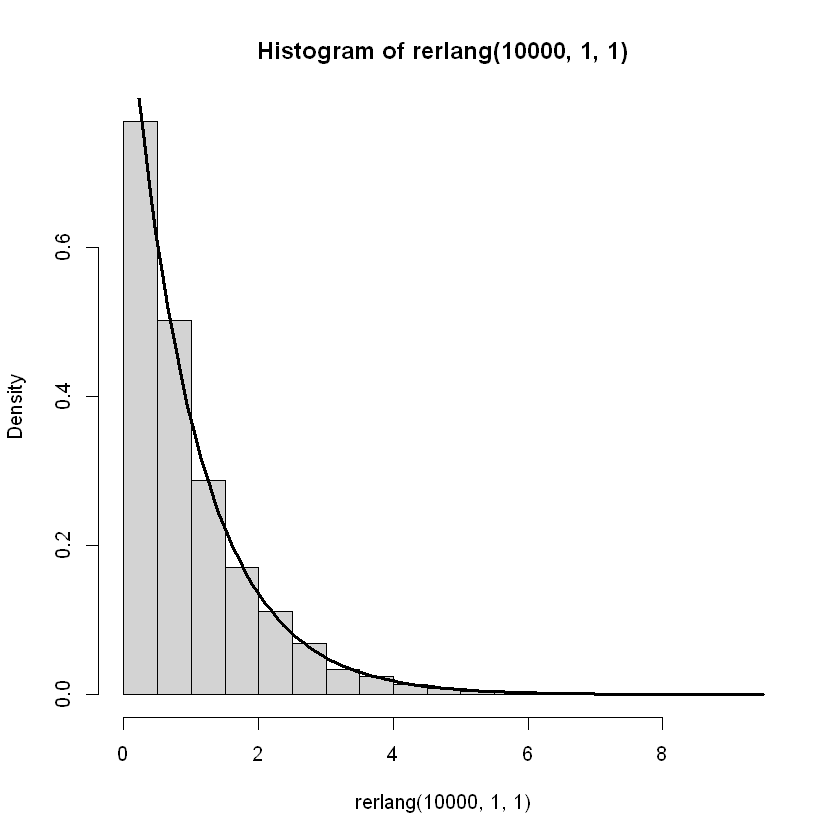

In [150]:
# Scelgo la prima opzione 

rerlang <- function(n, lambda, m){
    x <- rep(0,n) 
    # n è il numero di samples che voglio estrarre randomicamente dalla Erlang
    for (i in 1:n) x[i] <- -1/lambda*sum(log(runif(m)))
    # lambda è il reciproco di beta mentre m corrisponde ad alpha 
    return(x)
}

x <- seq(1,10000)

hist(rerlang(10000,1,1), freq=FALSE)
curve(dgamma(x,1,1),add = TRUE, lwd = 3)
# sfrutto la definizio per cui la Erlang è un caso particolare della gamma distribution per sovrapporre all'istogramma dei samples che sono 
# stati estratti manualmente quelli che invece provengono dalla dgamma con gli stessi parametri della erlang

## Esercizio 4 - Random numbers generator 

Per implementare il generatore di numeri casuali di Von Neumann si fissa un numero (come un seed da imporre nel generatore di r base per la ripetibilità delle estrazioni), si eleva al quadrato e si estrae da esso un numero avente tante cifre quante quello iniziale eliminando l'inizio e la parte finale. 


In [226]:
n <- 2343

randomnumber <- function(n){
    lenseed <- function(n) length(unlist(strsplit(as.character(n),"")))
    # questa funzione serve per contare il numero di cifre nel seed iniziale per confrontarle successivamente con il numero di cifre del quadrato

    number <- unlist(strsplit(as.character(n*n),""))
    # innanzitutto bisogna controllare che il numero di elementi sia 2n così da poter identificare una parte centrale nel numero. Se ci dovessero 
    # essere meno cifre del previsto si aggiungono 2n-lenseed zeri all'inizio come padding 
    len <- lenseed(n)

    numbercheck <- function(n,number) {
        if(length(number) < 2*len) number <- c(rep(0,2*len-length(number)),number)
        else number <- number 
        return(number)
        }

    number <- numbercheck(n,number)
    number <- number[-c((1:(len/2)),((length(number)-len/2+1):length(number)))]
    return(as.numeric(paste(number, collapse="")))
    }

sprintf("Il primo numero casuale estratto dal seed %i è %i", n, randomnumber(n))

[1] "Il primo numero casuale estratto dal seed 2343 è 4896"

In [225]:
# sfrutto alcune funzioni di approssimazione di R come floor e le divisioni per le potenze di dieci 

n2 <- 1234

randomnumber1 <- function(n){
    number2 <- n2**2
    len2 <- lenseed(n2)
    number2.without.last <- floor(number2/(10^(len2/2)))
    # adesso devo eliminare le most significant digits del numero fino ad ottenerne soltanto uno con quattro cifre, quante len1. Per farlo 
    # applichiamo nuovamente il metodo precedente: dividiamo per 10^len1 e prendiamo il floor, poi moltiplichiamo di nuovo per 10^d e sottraiamo
    # quanto ottenuto al risultato precedente 

    number2 <- number2.without.last - floor(number2.without.last/10^len2)*10^len2
    return(number2)
    }

sprintf("Il primo numero casuale estratto dal seed %i è %i", n2, randomnumber(n2))

[1] "Il primo numero casuale estratto dal seed 1234 è 5227"